In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.signal import detrend
from scipy import optimize 
import time 

import matplotlib as mpl

# These are some parameters to make figures nice (and big)
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

In [2]:
# Load data: I've gathered 20 variables for the lower 48 states: ERA5_gater_regional_data.ipynb
# daily JJA data 1979-2021

path='/data/keeling/a/cristi/a/data_processed/ERA5_JJA_daily/'
fname=path+'ERA5_JJA_daily_1979-2021_US48_20vars.nc'
ds=xr.open_dataset(fname).load()
ds

<xarray.Dataset>
Dimensions:    (latitude: 105, longitude: 237, time: 3956)
Coordinates:
  * time       (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2021-08-31
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 293.5 293.8 294.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
Data variables:
    t2m        (time, latitude, longitude) float32 291.2 290.9 ... 300.5 300.6
    t2max      (time, latitude, longitude) float32 297.1 298.9 ... 301.3 301.3
    d2m        (time, latitude, longitude) float32 283.5 283.1 ... 295.9 295.9
    swvl1      (time, latitude, longitude) float32 0.1086 0.2378 ... 0.1869
    swvl2      (time, latitude, longitude) float32 0.1314 0.2887 ... -1.304e-07
    swvl3      (time, latitude, longitude) float32 0.1285 0.2952 ... 2.58e-06
    swvl4      (time, latitude, longitude) float32 0.1618 0.3859 ... 0.0 0.0
    ssr        (time, latitude, longitude) float32 1.082e+06 ... 8.259e+05
    str        (time, latitude, longitude) float32 -2.765e+05 ... -2.135e+05
    sshf       (time, latitude, longitude) float32 -7.727e+04 ... -1.693e+04
    slhf       (time, latitude, longitude) float32 -2.062e+05 ... -2.567e+05
    e          (time, latitude, longitude) float32 -8.244e-05 ... -0.0001027
    ro         (time, latitude, longitude) float32 1.687e-05 3.696e-05 ... 0.0
    tp         (time, latitude, longitude) float32 0.0 0.0 ... 1.762e-05
    skt        (time, latitude, longitude) float32 289.5 291.4 ... 302.0 301.9
    stl1       (time, latitude, longitude) float32 287.7 289.2 ... 302.2 302.1
    z500       (time, latitude, longitude) float32 5.677e+04 ... 5.762e+04
    t850       (time, latitude, longitude) float32 285.1 285.1 ... 290.3 290.3
    t500       (time, latitude, longitude) float32 259.7 259.6 ... 268.2 268.2
    t700       (time, latitude, longitude) float32 275.6 275.5 ... 282.9 282.9

In [3]:
# lat-lon values for a few locations

D=[{'location':'DOE SGP ARM','lat':36.6,'lon':360-97.5},
   {'location':'Wichita KS','lat':37.68,'lon':360-97.33},
   {'location':'Washington DC','lat':38.9,'lon':360-77.0},
   {'location':'Atlanta','lat':33.74,'lon':360-84.4},
   {'location':'Dallas, TX','lat':32.77,'lon':360-96.8},
   {'location':'Denver, CO','lat':39.7,'lon':360-104.99},
   {'location':'Chicago, IL','lat':41.9,'lon':360-87.6},
   {'location':'Minneapolis ','lat':39.7,'lon':360-104.99},
   {'location':'Seattle, WA','lat':47.6,'lon':360-122.3},
   {'location':'Las Vegas, NV','lat':36.17,'lon':360-115.13},
   {'location':'Los Angeles, CA','lat':34.05,'lon':360-118.24},
   {'location':'New York, NY','lat':40.71,'lon':360-74.00}]

In [4]:
# Choose location and extract data
ind=8

lat=D[ind]['lat']
lon=D[ind]['lon']
location=D[ind]['location']
print(location)

#extract data for one location
ds_loc=ds.sel(latitude=lat,longitude=lon,method='nearest')
m=(ds_loc.swvl1-ds_loc.swvl1.min())/(ds_loc.swvl1.max()-ds_loc.swvl1.min())
ds_loc=ds_loc.assign(m=m)


Seattle, WA


# Coupled Model

In [5]:
def model(theta,ds_loc):

    # physical parameters        
    alpha_s=theta[0]
    alpha_r=theta[1]
    nu     =theta[2]
    mu     =theta[3]
    V      =theta[4] 
    m0     =theta[5]
    L    =2.5E6
    gamma=3.7E-4*1

    
    # Define a higher resolution time mesh (e.g. )
    dn   =0.01# [days]
    dt   =dn*24*60*60 # [s]
    to   =np.arange(0,len(ds_loc.time))
    ti   =np.arange(0,len(ds_loc.time),dn)

    # preallocate variables
    Mi   =np.zeros(len(ti))
    Ti   =np.zeros(len(ti))
    Ti[0]=ds_loc.t2m[0]
    
    # Interpolate forcing terms
    Fswi =np.interp(ti,to,ds_loc.ssr/3600)
    Pi   =np.interp(ti,to,ds_loc.tp)
    Tdi  =np.interp(ti,to,ds_loc.d2m)
    

    #Reference temp
    Td   =np.mean(ds_loc.d2m.values)
    Fsw  =np.mean(Fswi)
    
    print(Td, Fsw)
    print(np.std(ds_loc.d2m.values), np.std(Fswi))
    C    =40000
    
    
    for j in range(len(ti)-2):
        Mi[j+1]=Mi[j]+dt/mu * (Pi[j]/V  - nu*gamma*Mi[j]*(Ti[j]-Td))    
        if Mi[j+1]>1:
            Mi[j+1]=1
        if Mi[j+1]<0:
            Mi[j+1]=0

        Ti[j+1]=Ti[j]+dt/C* (Fswi[j] - 50 - (alpha_s+alpha_r+1*L*nu*gamma*(Mi[j]+m0))*(Ti[j]-Td))

    M   =np.interp(to,ti,Mi)
    T   =np.interp(to,ti,Ti)
    return M,T

def nullcline (theta):
    alpha_s=theta[0]
    alpha_r=theta[1]
    nu     =theta[2]
    mu     =theta[3]
    V      =theta[4] 
    m0     =theta[5]
    L    =2.5E6
    gamma=3.7E-4*1
    Fsw=ds_loc.ssr/3600
    
    LE=np.mean(Fsw)*L*nu*gamma*(m+m0)/(alpha_s+alpha_r+L*nu*gamma*(m+m0))
    SH=np.mean(Fsw)*alpha_s/(alpha_r+alpha_s+L*nu*gamma*(m+m0) )
    LW=np.mean(Fsw)*alpha_r/(alpha_r+alpha_s+L*nu*gamma*(m+m0))
    T   =np.mean(Fsw)/(alpha_r+alpha_s+L*nu*gamma*(m+m0))+np.mean(ds_loc.d2m)
    
    return T,LE,SH,LW

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [10]:
alpha_s=6
alpha_r=7
nu   =0.013
mu   =32
V    =6
m0   =0.68

L    =2.5E6
gamma=3.7E-4*1


theta_i=[alpha_s,alpha_r,nu,mu,V,m0]
M,T=model(theta_i,ds_loc)

Tn,LE,SH,LW=nullcline(theta_i)



285.30115 216.13748643662024
2.127125 62.000301920362816


### Plots

<ipython-input-11-31e8cac91cf0>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_xticklabels(['0','1','2','3','4','5','6', '7', '8', '9', '10'])


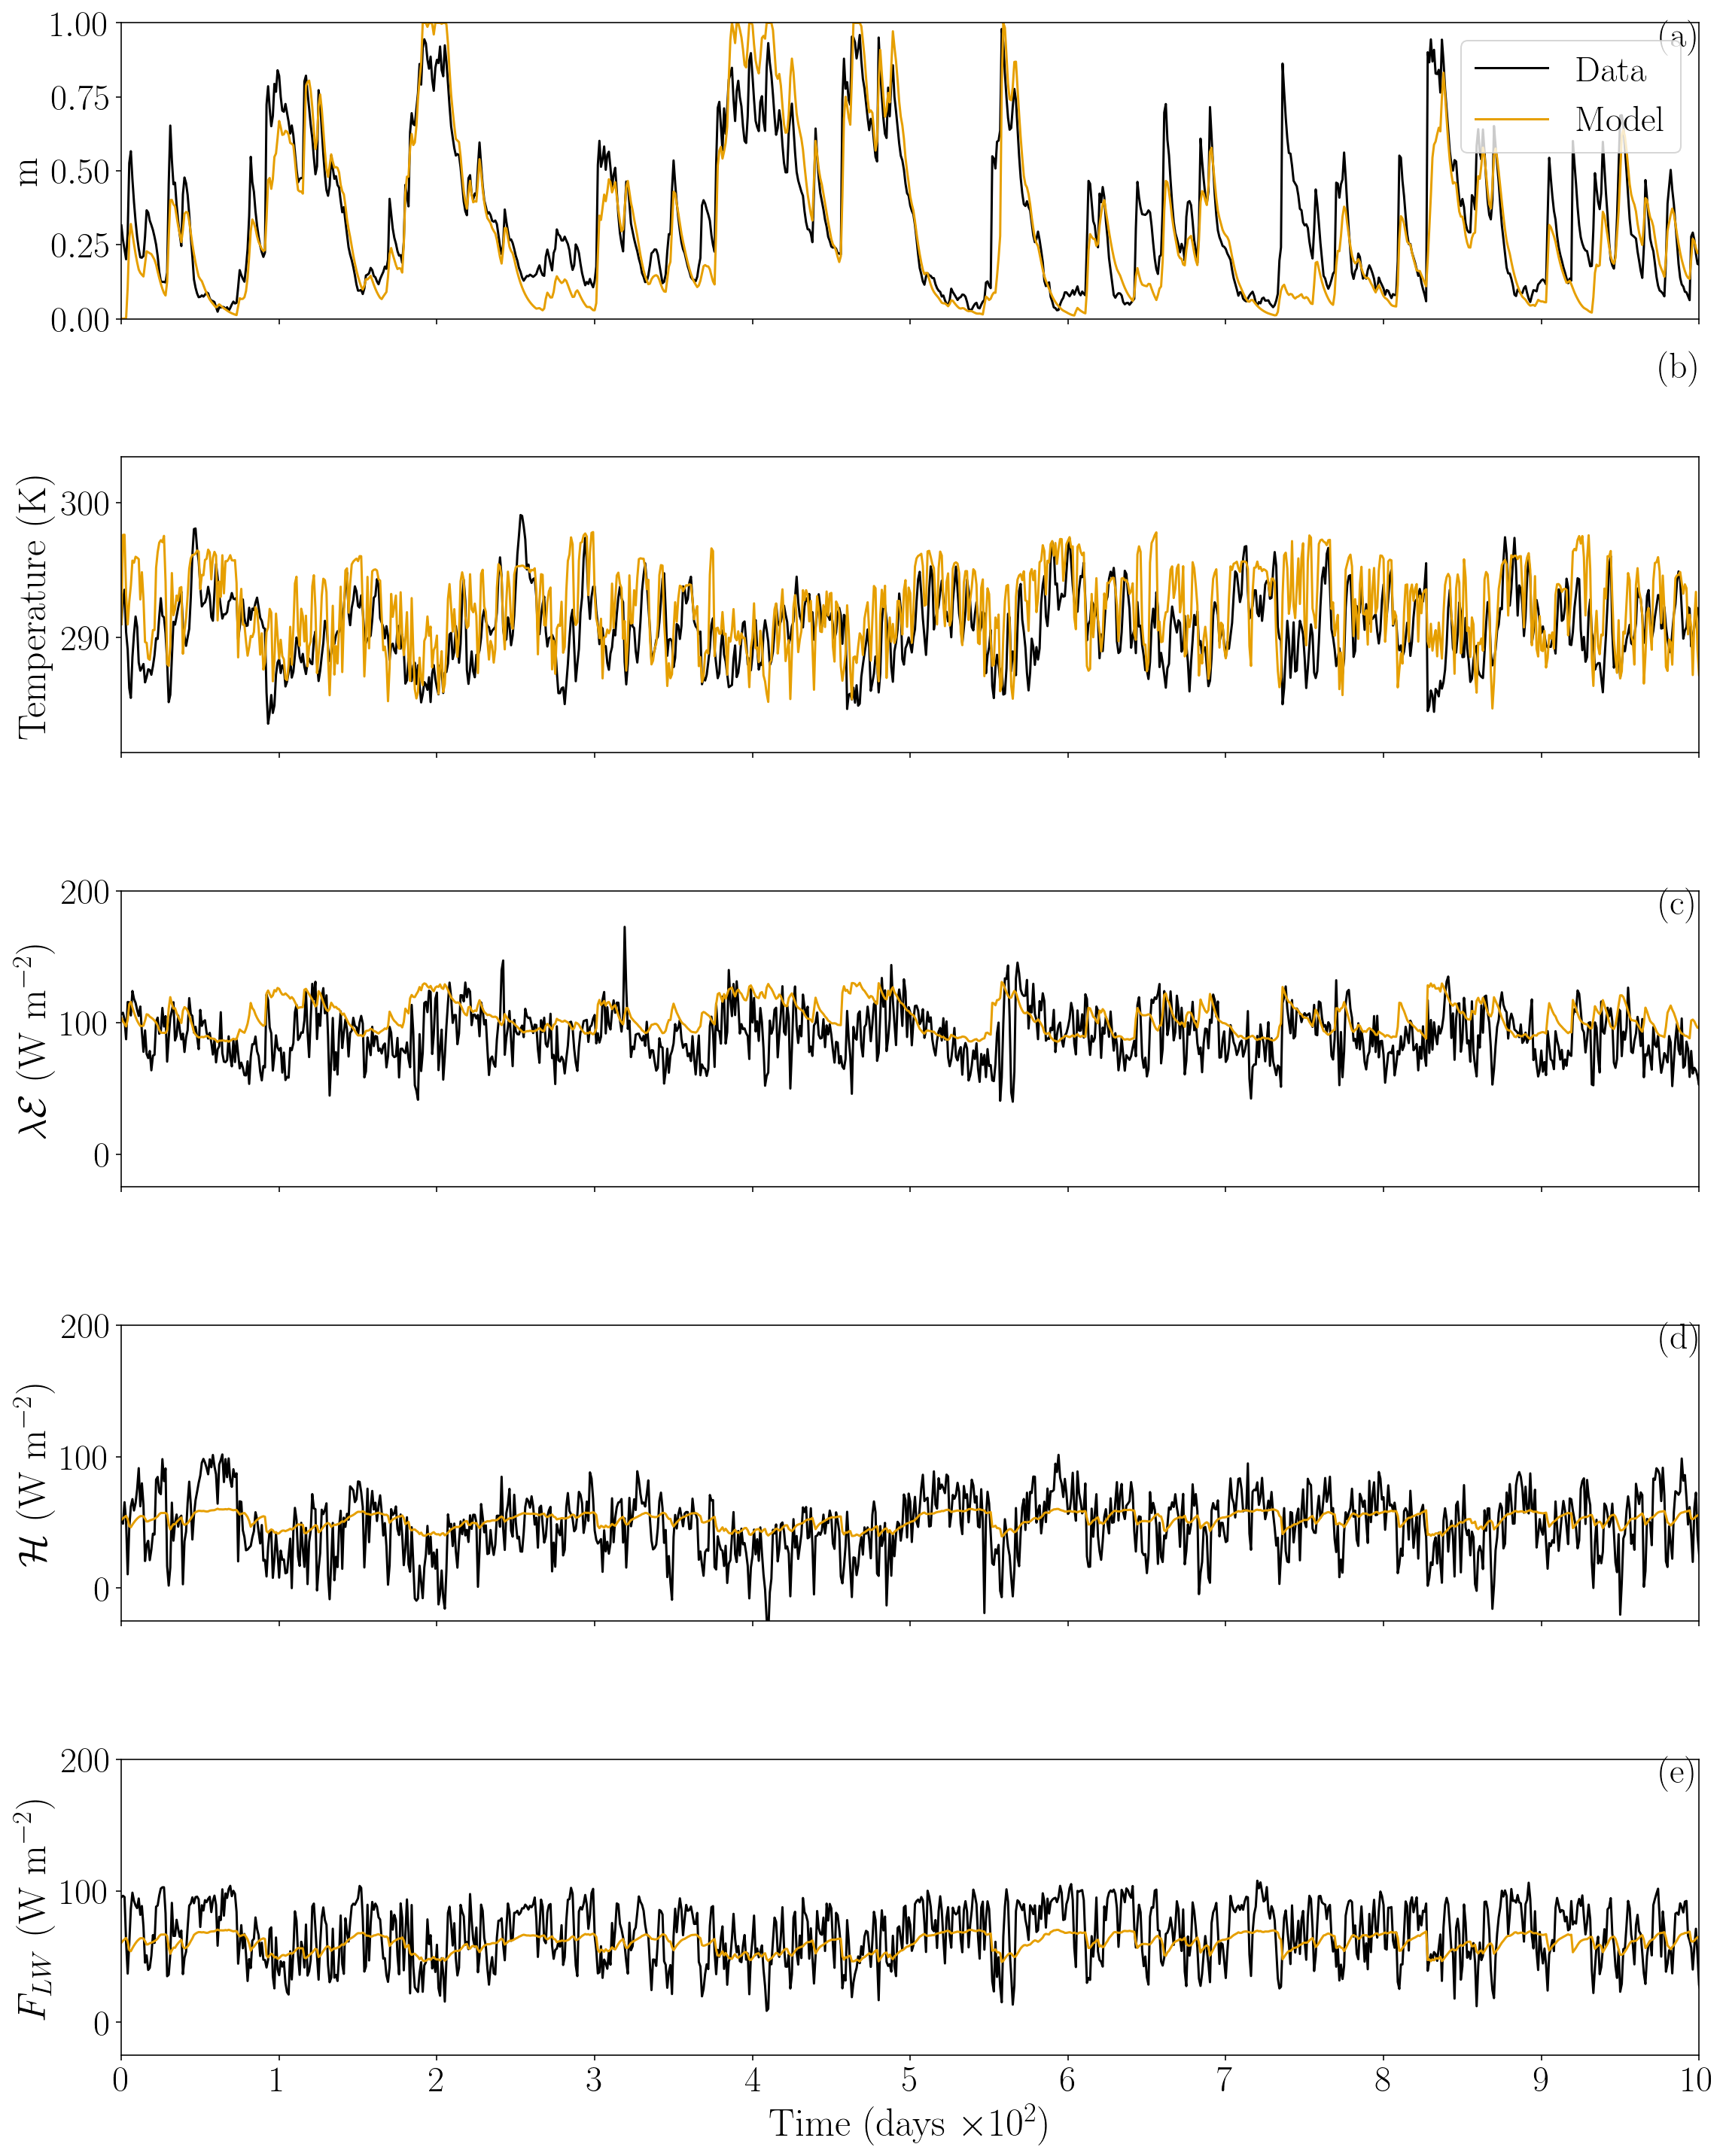

In [11]:
fig,ax=plt.subplots(5,1,figsize=[16,20], sharex=True)

# interval to plot
#xx=np.arange(0,900)
xlims=[0,1000]
ndays=1

tick_leg_size = 24
axis_label_size = tick_leg_size + 2

Tm =moving_average(T,ndays)
LEm=moving_average(LE.values,ndays)
SHm=moving_average(SH.values,ndays)
LWm=moving_average(LW.values,ndays)
Fsw  =ds_loc.ssr/3600


for i in range(0,5):
    ax[i].tick_params(axis='y', labelsize=tick_leg_size)    


ax[0].plot(ds_loc.m,label='Data',color='k')
ax[0].set_ylabel('m', fontsize=axis_label_size)
ax[0].plot(M,label='Model', color='#E69F00')
ax[0].set_xlim(xlims)
ax[0].set_ylim(0,1)
ax[0].legend(fontsize=tick_leg_size)

ax[1].plot(ds_loc.t2m.rolling(time=ndays).mean(), color='k')
ax[1].plot(Tm, color='#E69F00')
ax[1].set_ylabel('Temperature (K)', fontsize=axis_label_size)
ax[1].set_xlim(xlims)

data=-ds_loc.slhf.rolling(time=ndays,center=True).mean().dropna(dim='time')/3600
ax[2].plot(data, color='k')

ax[2].plot(LEm, color='#E69F00')
ax[2].set_xlim(xlims)
ax[2].set_ylabel('$\lambda \mathcal{E}$ (W m$^{-2}$)', fontsize=axis_label_size)
ax[2].set_ylim(-25,200)

data=-ds_loc.sshf.rolling(time=ndays,center=True).mean().dropna(dim='time')/3600
ax[3].plot(data, color='k')
ax[3].plot(SHm, color='#E69F00')
ax[3].set_xlim(xlims)
ax[3].set_ylim(-25,200)
ax[3].set_ylabel('$\mathcal{H}$ (W m$^{-2}$)', fontsize=axis_label_size)


data=-ds_loc.str.rolling(time=ndays,center=True).mean().dropna(dim='time')/3600
ax[4].plot(data, color='k')
ax[4].plot(LWm, color='#E69F00')
ax[4].set_xlim(xlims)
ax[4].set_ylim(-25,200)
ax[4].set_ylabel('$F_{LW}$ (W m$^{-2}$)', fontsize=axis_label_size)

ax[4].set_xlabel(r"Time (days $\times 10^{2}$)", fontsize=axis_label_size)
ax[4].set_xticklabels(['0','1','2','3','4','5','6', '7', '8', '9', '10'])
counter = 100
ax[4].set_xticks([0, counter, 2* counter, 3 * counter, 4 * counter, 5 * counter, 6* counter, 700, 800, 900, 1000])
ax[4].tick_params(axis='x', labelsize=tick_leg_size)

"""
for i in range(0,5):
    ax[i].axvspan(113, 175, alpha=0.4, color='#009E73')
    ax[i].axvline(113, 0, 1, color='#009E73')
    ax[i].axvline(175, 0, 1, color='#009E73')
    
    ax[i].axvspan(405, 450, alpha=0.4, color='#009E73')
    ax[i].axvline(405, 0, 1, color='#009E73')
    ax[i].axvline(450, 0, 1, color='#009E73')
    
    ax[i].axvspan(490, 525, alpha=0.4, color='#009E73')
    ax[i].axvline(490, 0, 1, color='#009E73')
    ax[i].axvline(525, 0, 1, color='#009E73')
    
    ax[i].axvspan(680, 710, alpha=0.4, color='#009E73')
    ax[i].axvline(680, 0, 1, color='#009E73')
    ax[i].axvline(710, 0, 1, color='#009E73')
    
    ax[i].axvspan(788, 808, alpha=0.4, color='#009E73')
    ax[i].axvline(788, 0, 1, color='#009E73')
    ax[i].axvline(808, 0, 1, color='#009E73')
"""
    
ax[0].text(975, 0.92, "(a)", fontsize=24)
ax[1].text(974.5, 309.25, "(b)", fontsize=24)
ax[2].text(975, 182.5, "(c)", fontsize=24)
ax[3].text(975, 182.5, "(d)", fontsize=24)
ax[4].text(975, 182.5, "(e)", fontsize=24)

fig.tight_layout()
#fig.savefig("figures/1-19-2022-era5-timeseries-fit.png", dpi=400)

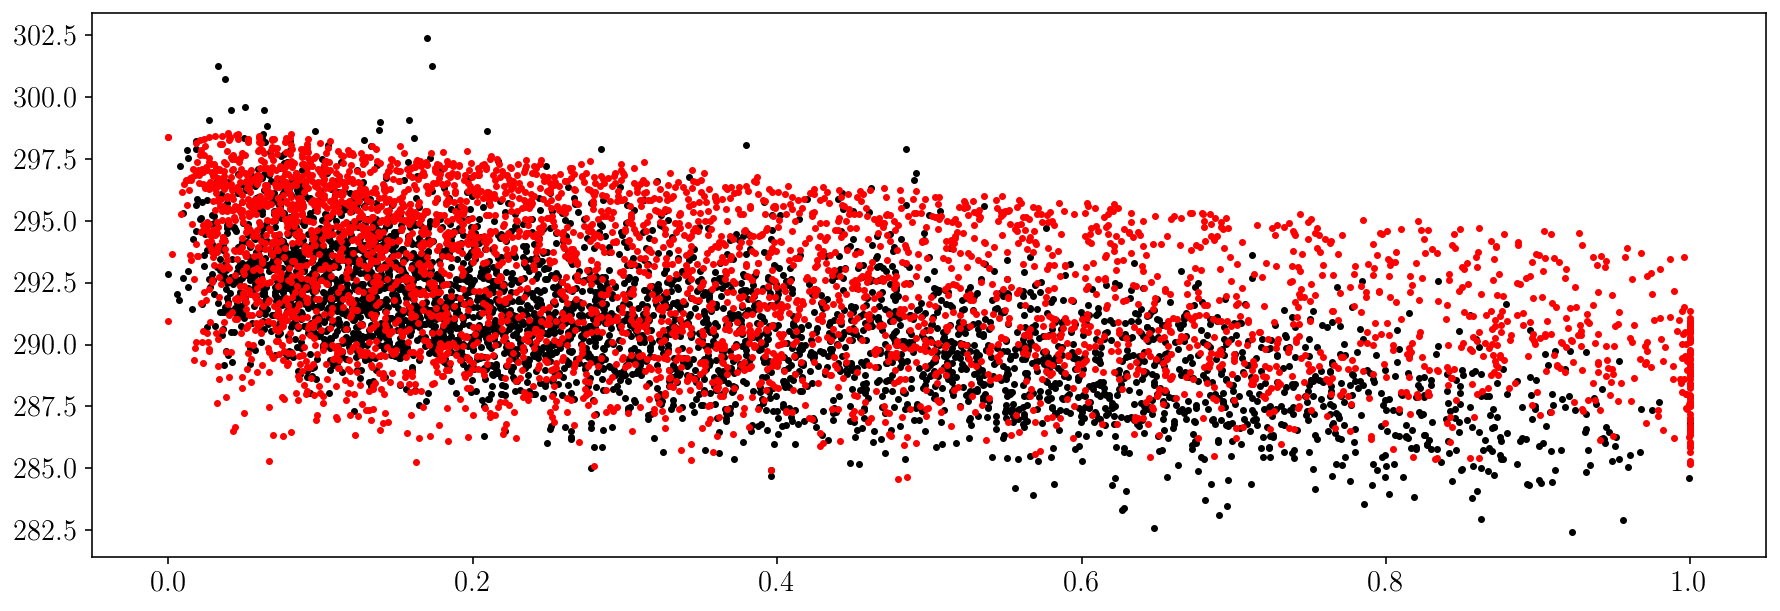

In [30]:


plt.subplot(1,1,1)    
msize=5
xx=np.arange(len(M))
plt.plot(ds_loc.m,ds_loc.t2m,'.',markersize=msize, color='k')
plt.plot(M,T,'.',markersize=msize,color='r')


#plt.ylim(285,310)

(0.0, 2.0)

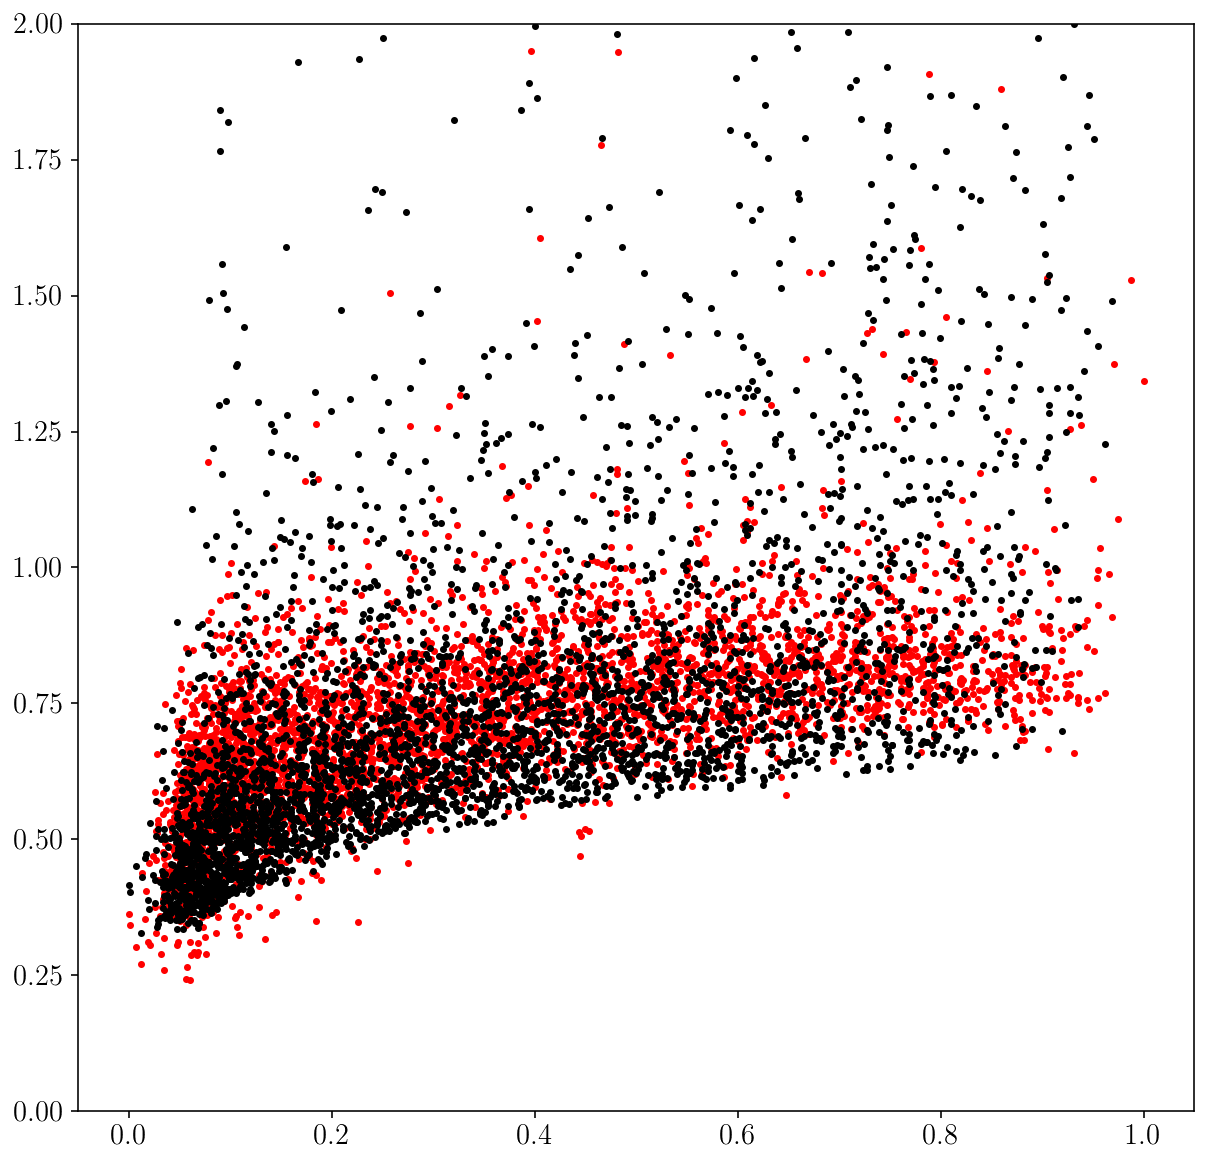

In [9]:

EF_obs=(ds_loc.slhf)/(ds_loc.ssr+ds_loc.str)
EF_mod=L*nu*gamma*(m+m0)/(Fsw/np.mean(Fsw)*(alpha_r+alpha_s+L*nu*gamma*(m+m0))-alpha_r)

plt.figure(figsize=[10,10])
msize=5

plt.plot(ds_loc.m,-EF_obs,'r.',markersize=msize,label='ERA5')
plt.plot(m,EF_mod,'k.',markersize=msize,label='mode')
plt.ylim(0,2)

In [10]:
# Misc: Model with noise? 

In [11]:
def model_w_noise(theta,ds_loc):

    # physical parameters        
    alpha_s=theta[0]
    alpha_r=theta[1]
    nu     =theta[2]
    mu     =theta[3]
    V      =theta[4] 
    m0     =theta[5]
    L    =2.5E6
    gamma=3.7E-4*1
    

    
    # Define a higher resolution time mesh (e.g. )
    dn   =0.01# [days]
    dt   =dn*24*60*60 # [s]
    to   =np.arange(0,len(ds_loc.time))
    ti   =np.arange(0,len(ds_loc.time),dn)

    # preallocate variables
    Mi   =np.zeros(len(ti))
    Ti   =np.zeros(len(ti))
    Ti[0]=ds_loc.t2m[0]
    
    # Interpolate forcing terms
    Fswi =np.interp(ti,to,ds_loc.ssr/3600)
    Pi   =np.interp(ti,to,ds_loc.tp)
    Tdi  =np.interp(ti,to,ds_loc.d2m)
    

    #Reference temp
    Td   =np.mean(ds_loc.d2m.values)
    Fsw  =np.mean(Fswi)
    C    =40000
    
    # Add a noise term
    eta=np.interp(ti,to,ds_loc.z500)
    eta=(eta-np.mean(eta))/np.std(eta)
    phi=1.25

    
    for j in range(len(ti)-2):
        Mi[j+1]=Mi[j]+dt/mu * (Pi[j]/V  - nu*gamma*Mi[j]*(Ti[j]-Td+phi*eta[j]))    
        if Mi[j+1]>1:
            Mi[j+1]=1
        if Mi[j+1]<0:
            Mi[j+1]=0

        Ti[j+1]=Ti[j]+dt/C* (Fswi[j]-50 - (alpha_s+alpha_r+1*L*nu*gamma*(Mi[j]+m0))*(Ti[j]-Td+phi*eta[j]))

    M   =np.interp(to,ti,Mi)
    T   =np.interp(to,ti,Ti)
    return M,T

In [12]:
alpha_s=4
alpha_r=8
nu   =0.03
mu   =40
V    =5
m0   =0.1

L    =2.5E6
gamma=3.7E-4*1


theta_i=[alpha_s,alpha_r,nu,mu,V,m0]
M,T=model_w_noise(theta_i,ds_loc)

Text(0, 0.5, 'LW')

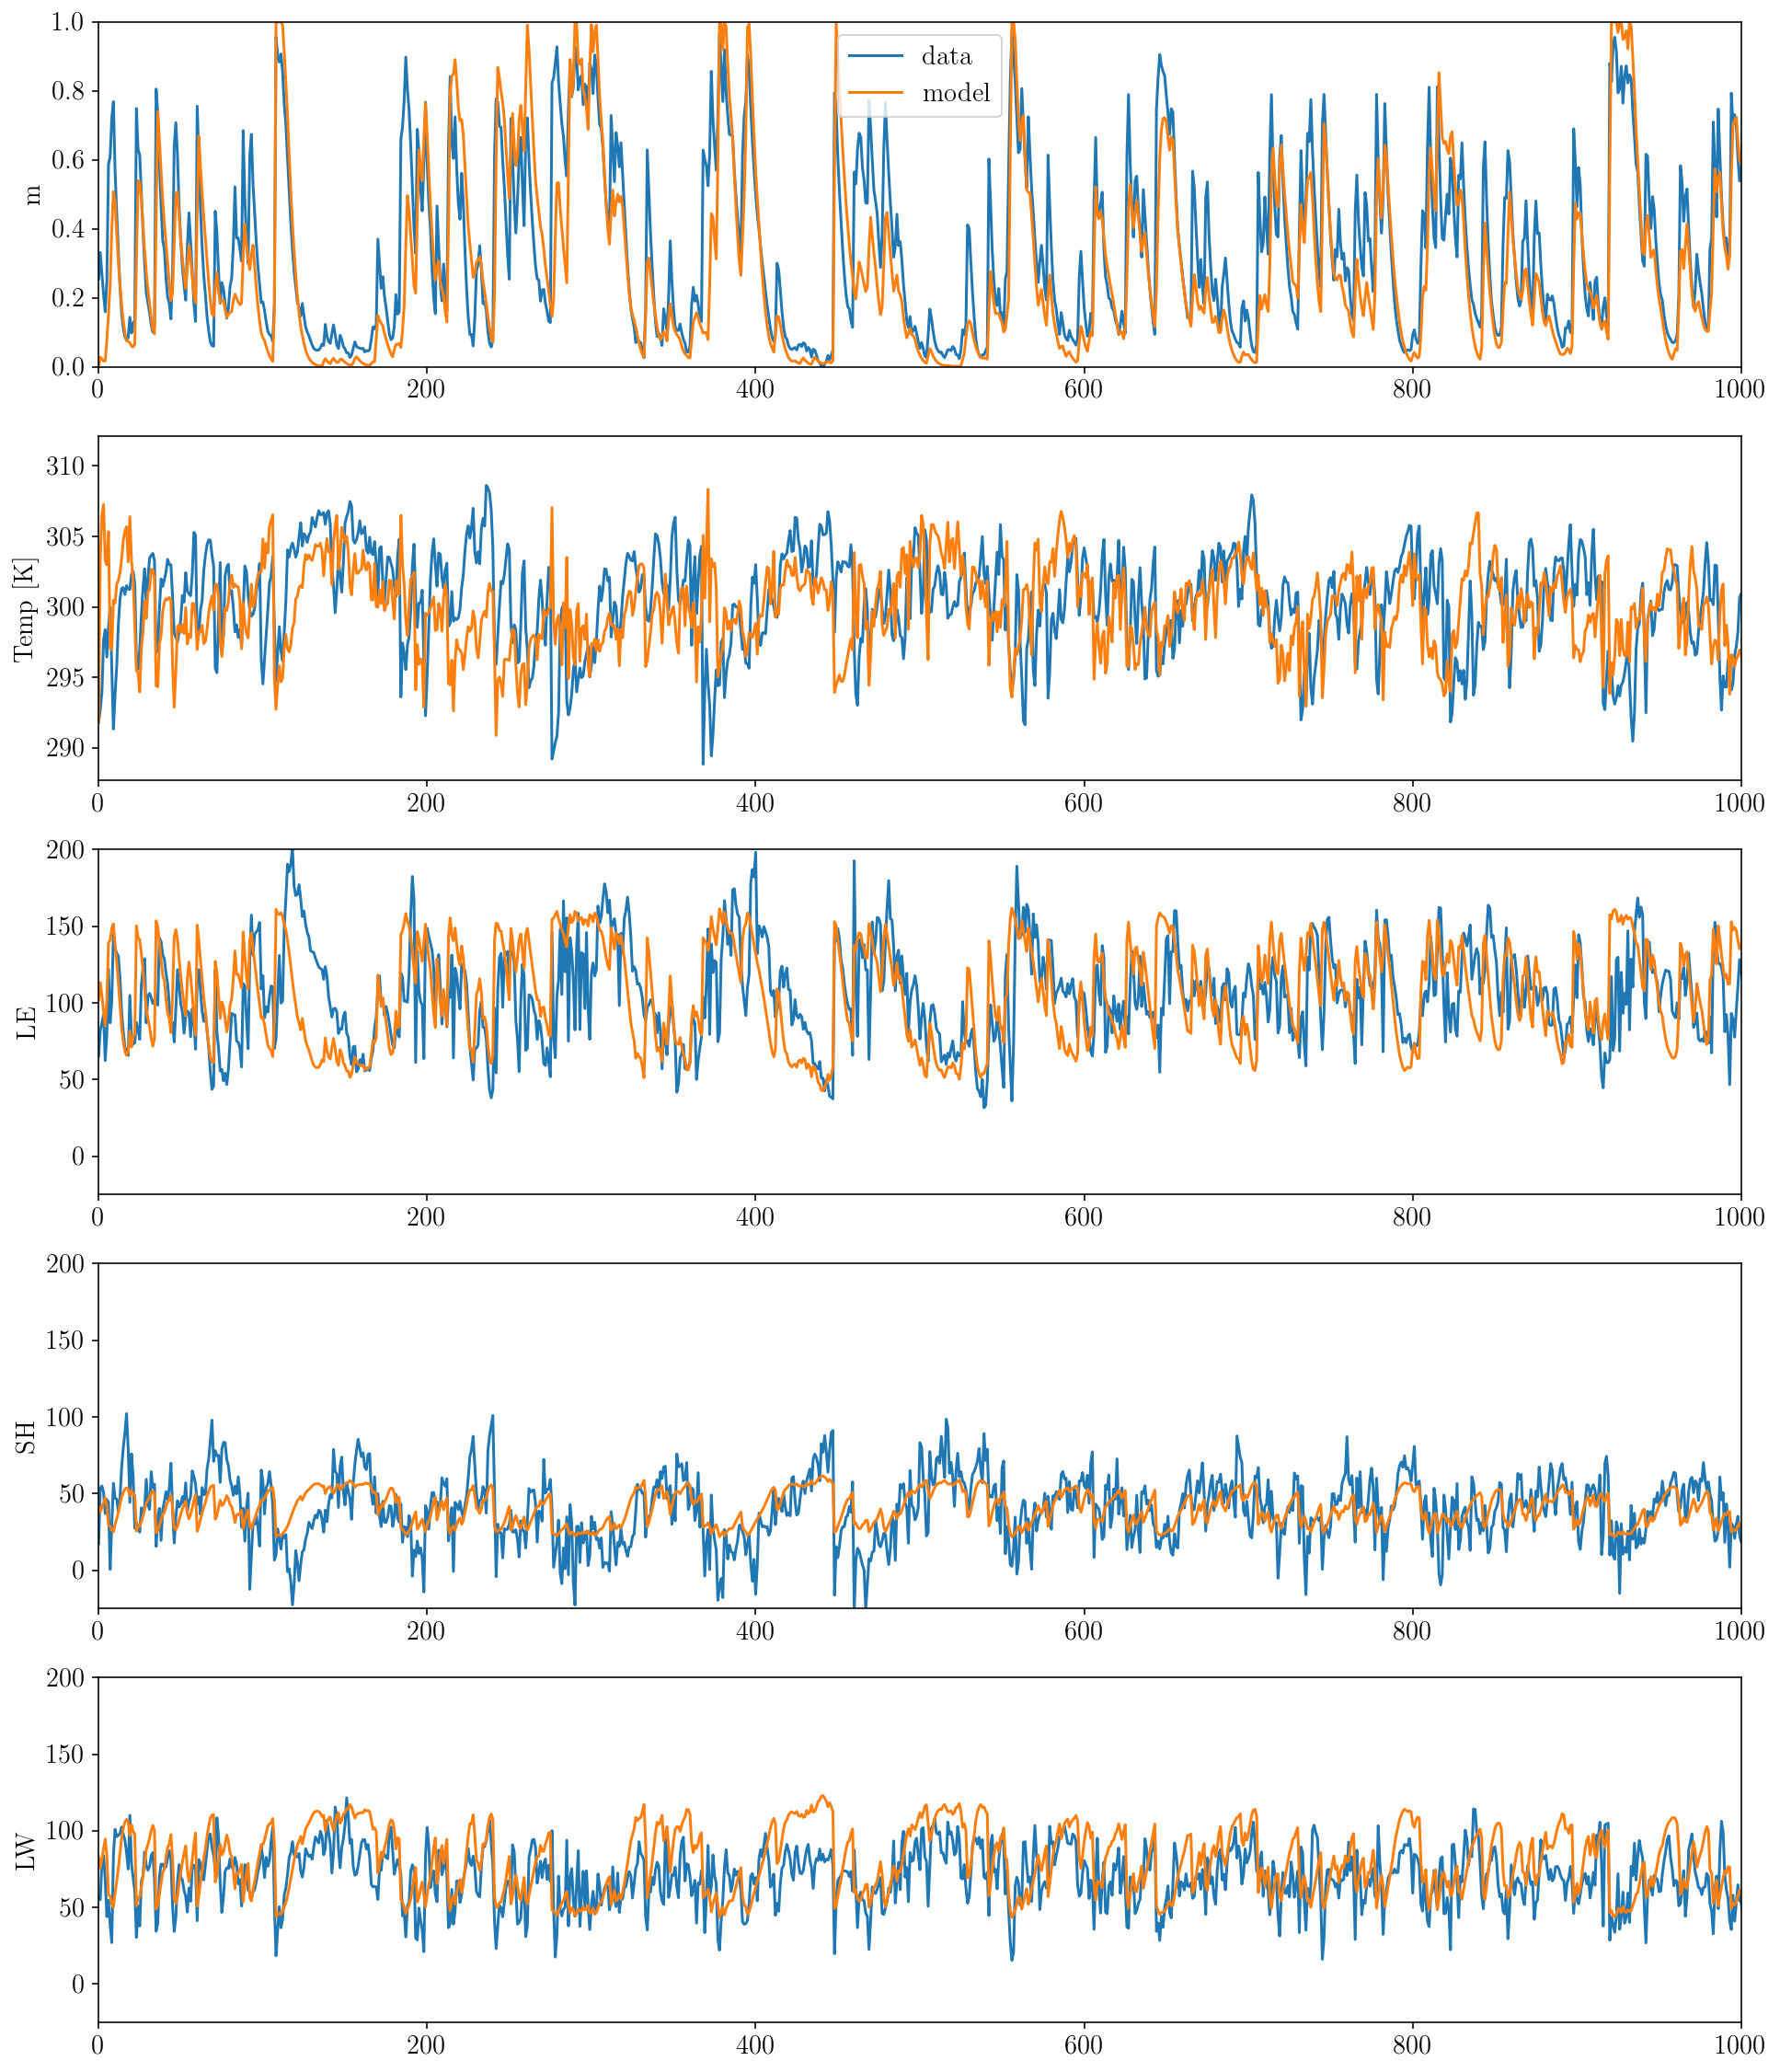

In [13]:
fig,ax=plt.subplots(5,1,figsize=[16,20])

# interval to plot
#xx=np.arange(0,900)
xlims=[0,1000]
ndays=1

Tm =moving_average(T,ndays)
LEm=moving_average(LE.values,ndays)
SHm=moving_average(SH.values,ndays)
LWm=moving_average(LW.values,ndays)
Fsw  =ds_loc.ssr/3600




ax[0].plot(ds_loc.m,label='data')
ax[0].set_ylabel('m')
ax[0].plot(M,label='model')
ax[0].set_xlim(xlims)
ax[0].set_ylim(0,1)
ax[0].legend()

ax[1].plot(ds_loc.t2m.rolling(time=ndays).mean())
ax[1].plot(Tm)
ax[1].set_ylabel('Temp [K]')
ax[1].set_xlim(xlims)




data=-ds_loc.slhf.rolling(time=ndays,center=True).mean().dropna(dim='time')/3600
ax[2].plot(data)

ax[2].plot(LEm)
ax[2].set_xlim(xlims)
ax[2].set_ylabel('LE')
ax[2].set_ylim(-25,200)

data=-ds_loc.sshf.rolling(time=ndays,center=True).mean().dropna(dim='time')/3600
ax[3].plot(data)
ax[3].plot(SHm)
ax[3].set_xlim(xlims)
ax[3].set_ylim(-25,200)
ax[3].set_ylabel('SH')


data=-ds_loc.str.rolling(time=ndays,center=True).mean().dropna(dim='time')/3600
ax[4].plot(data)
ax[4].plot(LWm)
ax[4].set_xlim(xlims)
ax[4].set_ylim(-25,200)
ax[4].set_ylabel('LW')



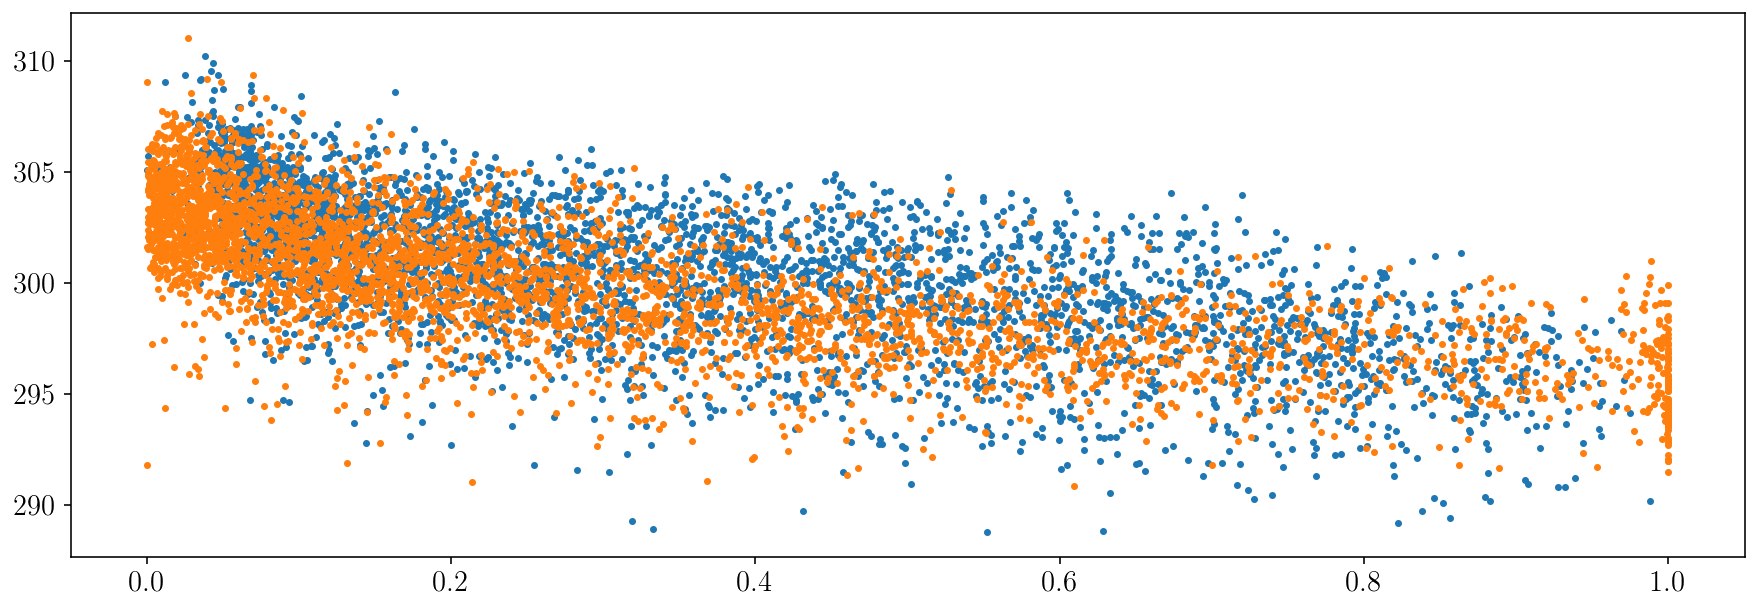

In [14]:

plt.subplot(1,1,1)    
msize=5
xx=np.arange(len(M))
plt.plot(ds_loc.m,ds_loc.t2m,'.',markersize=msize)
plt.plot(M,T,'.',markersize=msize)


#plt.ylim(285,310)